In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from urllib.error import HTTPError, URLError
from urllib.parse import urlencode

plt.rcParams['font.sans-serif'] = 'Simhei'
plt.rcParams['axes.unicode_minus'] = False

In [136]:
#沪市前面加0，深市前面加1，比如0000001，是上证指数，1000001是中国平安
def get_daily(code, start='19900101', end=''):
    url_mod = "http://quotes.money.163.com/service/chddata.html?code=%s&start=%s&end=%s"
    url = url_mod % (code, start, end)
    df = pd.read_csv(url, encoding='gb2312')
    return df


df = get_daily('0000001')  # 获取上证指数

In [137]:
df.sort_index(ascending=False)

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值,成交笔数
7655,1990-12-19,'000001,上证指数,99.9800,99.9800,95.7900,96.0500,None,None,None,NaN,1260,494000.0,NaN,NaN,None
7654,1990-12-20,'000001,上证指数,104.3900,104.3900,99.9800,104.3000,99.98,4.41,4.4109,NaN,197,84000.0,NaN,NaN,None
7653,1990-12-21,'000001,上证指数,109.1300,109.1300,103.7300,109.0700,104.39,4.74,4.5407,NaN,28,16000.0,NaN,NaN,None
7652,1990-12-24,'000001,上证指数,114.5500,114.5500,109.1300,113.5700,109.13,5.42,4.9666,NaN,32,31000.0,NaN,NaN,None
7651,1990-12-25,'000001,上证指数,120.2500,120.2500,114.5500,120.0900,114.55,5.7,4.976,NaN,15,6000.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2022-04-14,'000001,上证指数,3225.6412,3240.0014,3200.2346,3203.6337,3186.8244,38.8168,1.218,NaN,371242344,4.01191632081e+11,NaN,NaN,None
3,2022-04-15,'000001,上证指数,3211.2448,3229.8655,3200.1332,3210.6996,3225.6412,-14.3964,-0.4463,NaN,407842082,4.13498819916e+11,NaN,NaN,None
2,2022-04-18,'000001,上证指数,3195.5240,3204.0274,3166.9782,3185.9428,3211.2448,-15.7208,-0.4896,NaN,347365123,3.66380807918e+11,NaN,NaN,None
1,2022-04-19,'000001,上证指数,3194.0287,3207.8276,3174.7138,3192.0924,3195.524,-1.4953,-0.0468,NaN,339944104,3.62769876686e+11,NaN,NaN,None


In [145]:
data = df.sort_index(ascending=False).loc[:, ['日期', '收盘价']]

In [146]:
data.set_index('日期', inplace=True)
data

,收盘价
日期,
1990-12-19,99.9800
1990-12-20,104.3900
1990-12-21,109.1300
1990-12-24,114.5500
1990-12-25,120.2500
...,...
2022-04-14,3225.6412
2022-04-15,3211.2448
2022-04-18,3195.5240


TypeError: Index(...) must be called with a collection of some kind, '股票' was passed

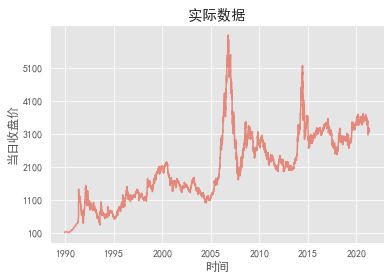

In [140]:
x = pd.to_datetime(data.index)
ax = plt.gca()
plt.style.use('ggplot')
ax.xaxis.set_major_locator(mdate.YearLocator())
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y'))  # 横坐标标签显示的日期格式
plt.xticks(pd.date_range(x[0], x[-1], freq='5y'))  # 横坐标日期范围及间隔
plt.yticks(range(100, 6000, 1000))  # 设置纵坐标，使用range()函数设置起始、结束范围及间隔步长
plt.xlabel("时间")
plt.ylabel("当日收盘价")
plt.title("实际数据")
plt.plot(x, data['收盘价'], alpha=0.6)
plt.show()

In [151]:
root = "https://app.finance.ifeng.com/list/stock.php"
# GET请求数据
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/99.0.4844.74 Safari/537.36"
}
data = {'t': 'hs', 'f': 'chg_pct', 'o': 'desc', 'p': 100}
params = urlencode(data)
url = root + '?' + params
req = Request(url=url, headers=headers, method='GET')
try:
    html = urlopen(req)
except HTTPError as e:
    print(e)
except URLError as e:
    print(e)
else:
    bs = BeautifulSoup(html, 'html.parser')
    lists = bs.find('div', {'class': 'tab01'})
    data = lists.find_all('a', {'target': '_blank'})
    if not data:
        print("No data found!")
    else:
        print(len(data))
        for item in data:
            print(item.get_text().replace(" ", ""))

No data found!


In [142]:
all_a = bs.find_all('a')
for a in all_a:
    a = str(a)
    m = re.match(r'^<a href="\?t=([a-zA-Z]+)">.*</a>$', a)
    if m is not None:
        print(m.group(1))

hs
ha
sa
kcb
hb
sb
cyb
zs
jj
etf
zq


In [143]:
import sys

In [144]:
sys.path[0]

'D:\\Program Files\\PyCharm 2021.2.3\\plugins\\python\\helpers-pro\\jupyter_debug'

In [148]:
urlencode(None)

TypeError: not a valid non-string sequence or mapping object

In [149]:
np.arange(1,100,2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])